## Data manipulation

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import numpy
import ipywidgets as widgets
from IPython.display import display

In [ ]:
from dataclasses import dataclass

@dataclass
class Statistics:
    count_years: int = None
    count_fill_values: int = None
    first_fill_year: int = None
    last_fill_year: int = None
    mean_value: float = None
    median_value: float = None
    max_value: int = None
    max_value_year: int = None
    min_value: float = None
    min_value_year: float = None
    standard_deviation: float = None
    quality_range_fill_data: int = None
    quality_range_unfill_data: int = None
    quality_data_info: str = None
    min_range_year: int = None
    max_range_year: int = None # otázka zda používat, je to informace pro range widget
    statistics_dictionary: dict = None
    
    def get_statistics_dict_info(self):
        self.statistics_dictionary = {
            'count_years': self.count_years,
            'count_fill_values': self.count_fill_values,            
            'first_fill_year': self.first_fill_year,
            'last_fill_year': self.last_fill_year,
            'mean_value': self.mean_value,
            'median_value': self.median_value,
            'max_value': self.max_value,
            'max_value_year': self.max_value_year,
            'min_value': self.min_value,
            'min_value_year': self.min_value_year,
            'standard_deviation': self.standard_deviation,
            'quality_range_fill_data': self.quality_range_fill_data,
            'quality_range_unfill_data': self.quality_range_unfill_data,
            'quality_data_info': self.quality_data_info, 
            'min_range_year': self.min_range_year,
            'max_range_year': self.max_range_year
        }
        # return statistics_dictionary
        

    def get_quality_data(self, data = None, idx_first_fill_year = None, idx_last_fill_year = None):
        if self.count_fill_values != 0:
            count_fill_values_range = data[idx_first_fill_year:(idx_last_fill_year + 1)]['value'].count()
            count_fill_year_range = data[idx_first_fill_year:(idx_last_fill_year + 1)]['year'].count()
            self.quality_range_fill_data = count_fill_year_range
            self.quality_range_unfill_data = count_fill_year_range - count_fill_values_range

            if count_fill_values_range == count_fill_year_range:
                self.quality_data_info = 'The time series has no missing values within the data disclosure period.'
            else:
                number = count_fill_year_range - count_fill_values_range
                self.quality_data_info = f'The time series has {number} missing value(s) within the data disclosure period.'
        else: 
            self.quality_range_fill_data = 0
            self.quality_range_unfill_data = 0
            self.quality_data_info = f'No record for crime.'

    def calculate_from_data(self, data, code):
        if code == '1-1':
            if data['value'].count() != 0:
                value_column = data['value']
                year_column = data['year']
                
                self.count_years = year_column.count()
                self.count_fill_values = value_column.count()

                idx_first_fill_year = value_column.first_valid_index()
                self.first_fill_year = year_column[idx_first_fill_year]
               
                idx_last_fill_year = value_column.last_valid_index()
                self.last_fill_year = year_column[idx_last_fill_year]
               
                self.mean_value = round(value_column.mean(), 2)
                self.median_value = value_column.median()

                max_value_row = data.loc[data['value'].idxmax()]
                min_value_row = data.loc[data['value'].idxmin()]

                self.max_value, self.max_value_year = max_value_row[['value', 'year']]
                self.min_value, self.min_value_year = min_value_row[['value', 'year']]

                # použita populační směrodatná odchylka, ddof=1 ->nastavení na výběrovou směrodatnou odchylku
                self.standard_deviation = round(numpy.std(value_column), 2)
                
                self.get_quality_data(data, idx_first_fill_year, idx_last_fill_year)
                self.get_statistics_dict_info()
                    

                # TODO: nutno pořešit v rámci změny filtrování, např. pokud budu mít všechny země, tento údaj úplně nědává smysl, 
                self.min_range_year = data['year'].min() 
                self.max_range_year = data['year'].max()
            else: 
                self.count_years = 0
                self.count_fill_values = 0
                self.first_fill_year = 0
                self.last_fill_year = 0
                self.mean_value = 0
                self.median_value = 0
                self.max_value = 0
                self.max_value_year = 0
                self.min_value = 0
                self.min_value_year = 0
                self.standard_deviation = 0
                self.min_range_year = 0
                self.max_range_year = 0
                self.get_quality_data()
                self.get_statistics_dict_info()


        elif code == '1-all':
            pass
        
        elif code == 'all-1':
            pass

        elif code == 'all-all':
            pass


@dataclass
class EurostatCrimeTable:
    data: pd.DataFrame = None
    country_list_sorted: list = None
    crime_list_sorted: list = None
    country: str = None
    crime: str = None
    filtered_data: pd.DataFrame = None
    filtered_code: None = None
    statistics: Statistics = None
    statistics_info: str = None

    
    def get_sorted_list(self, unpivot_data):
        country_list_sorted = sorted(list(set(unpivot_data['country_name'].tolist())))
        country_list_sorted.insert(0, 'all')
        self.country_list_sorted = country_list_sorted

        crime_list_sorted = sorted(list(set(unpivot_data['crime_info'].tolist())))
        crime_list_sorted.insert(0, 'all')
        self.crime_list_sorted = crime_list_sorted


    def load_data(self, path):
        data = pd.read_csv(path, sep='\t')
        
        data = data.rename({data.columns[0]: data.columns[0].replace(r"\TIME_PERIOD", "")}, axis="columns")
        split_name_columns = (data.columns[0]).split(',')
        count_split_columns = len(split_name_columns)
        data[split_name_columns] = data[data.columns[0]].str.split(',', expand=True)
        data = data.drop(data.columns[0], axis="columns") #odstraneni jiz rozdeleneho sloupce


        %run data/add_info.ipynb
        data = data.merge(geo_df, how='left', on='geo')
        data = data.merge(iccs_df, how='left', on='iccs')
        data = data.drop(columns=['geo', 'iccs'])

        # presun rozdelenych a naparovaných udaju  na zacatek df
        reorg_columns = data.columns.tolist()
        final_reorg_columns = reorg_columns[-count_split_columns:] + reorg_columns[:-count_split_columns]
        data = data[final_reorg_columns]

        data = data.replace(": ", 'NaN')

        column_period = data.columns[count_split_columns:] 
        data[column_period] = data[data.columns[count_split_columns:]].astype('float')
        
        no_anual = data[data['freq'] != 'A'].index # podminka, ze se nejedna o rocni data
        data.drop(index=no_anual, inplace=True)

        no_p_hthab = data[data['unit'] != 'P_HTHAB'].index # podminka, ze se nejedna o udaj na 100tis obyvatel
        data.drop(index=no_p_hthab, inplace=True)

        years_list = data.columns[count_split_columns:]
        info_list = data.columns[:count_split_columns]

        unpivot_data = pd.melt(data, id_vars=info_list, value_vars=years_list, var_name='year', value_name='value')
        unpivot_data['year'] = unpivot_data['year'].astype('int')
        
        self.get_sorted_list(unpivot_data)
        self.data = unpivot_data
        
    
    def filter_data(self, country, crime):
        self.country = country
        self.crime = crime
        # self.statistics = Statistics()

        # TODO: nahradit kody '1-1' novymi tridami, ktere budou dedit od Statistics()
        if country != 'all' and crime != 'all':
            filtered_data = self.data[(self.data['country_name'] == country) & (self.data['crime_info'] == crime)]
            filtered_data = filtered_data.sort_values(by='year', axis=0, ascending=True)
            # vznik noveho sloupce index!!
            self.filtered_data = filtered_data.reset_index()
            self.filtered_code = '1-1'
            # self.calc_func = self.statistics.calculate_from_data11 # fci ulozim jako parametr

        elif country != 'all' and crime == 'all':
            self.filtered_data = self.data[self.data['country_name'] == country]
            self.filtered_code = '1-all'
            # self.calc_func = self.statistics.calculate_from_data1all

        elif country == 'all' and crime != 'all':
            self.filtered_data = self.data[self.data['crime_info'] == crime]
            self.filtered_code = 'all-1'

        elif country == 'all' and crime == 'all':
            self.filtered_data = self.data
            self.filtered_code = 'all-all'


    def get_statistics(self):
        data = self.filtered_data
        code = self.filtered_code

        stat = Statistics()
        stat.calculate_from_data(data, code)
        # TODO zaktivnit calc_func
        # self.calc_func(data, code)
        self.statistics = stat
        if stat.last_fill_year != stat.max_range_year:
            info = f'Data disclosure by the country began in {stat.first_fill_year} and ended in {stat.last_fill_year}.'
        elif stat.last_fill_year == stat.max_range_year:
            info = f'Data disclosure by the country began in {stat.first_fill_year} and continues until {stat.max_range_year}.'

        self.statistics_info = f'During a {stat.count_years}-year period, {self.country} recorded {stat.count_fill_values} entries for {self.crime} types of crime. {info} Across these years, there were an average of {stat.mean_value} crimes per hundred thousand inhabitants each year and standard deviation was {stat.standard_deviation}. The minimum recorded crime rate per hundred thousand inhabitants was {stat.min_value} in {stat.min_value_year}, while the maximum was {stat.max_value} in {stat.max_value_year}.'

        # TODO: vyřešit info o státu/kriminalitě
        # TODO: 
        # přidat dodatečné  informace o směrodané odchylce
        # přidat info o násobku z min -> max aj
        # od jakého roku začal stát poskytovat/sbírat data - zmenit automaticky range ve widgete
        # vytvorit slovnik jako zaznamnik pro porovnani s ostatnimi zememi průmery, max, min v ráci tr. činnu
      
    def get_summarize_df_1all(self):
        dictionary_list = list()

        for country_name in self.country_list_sorted[1:]:
            for crime_name in self.crime_list_sorted[1:]:
               country_crime_dict = {'country': country_name, 'crime': crime_name}
               self.filter_data(country_name, crime_name)
               self.get_statistics()
               output_dictionary = self.statistics.statistics_dictionary
               country_crime_dict.update(output_dictionary)
               dictionary_list.append(country_crime_dict)
        country_crime_info_11 = pd.DataFrame.from_dict(dictionary_list)
        return country_crime_info_11
                # print(country_name)
                # print(crime_name)
                

    def __str__(self):
        print(f'info {self.statistics}')


In [13]:
CrimeData = EurostatCrimeTable()
CrimeData.load_data(f'data/estat_crim_off_cat.tsv')

In [14]:
sum_info = CrimeData.get_summarize_df_1all()

In [15]:
sum_info.tail(20)

,country,crime,count_years,count_fill_values,first_fill_year,last_fill_year,mean_value,median_value,max_value,max_value_year,min_value,min_value_year,standard_deviation,quality_range_fill_data,quality_range_unfill_data,quality_data_info,min_range_year,max_range_year
841,Türkiye,Attempted intentional homicide,0,0,0,0,0.00,0.00,0.00,0,0.00,0,0.00,0,0,No record for crime.,0.0,0.0
842,Türkiye,Bribery,15,1,2016,2016,2.18,2.18,2.18,2016,2.18,2016,0.00,1,0,The time series has no missing values within t...,NaN,NaN
843,Türkiye,Burglary,15,9,2009,2022,130.79,127.01,159.97,2012,114.18,2021,14.57,14,5,The time series has 5 missing value(s) within ...,NaN,NaN
844,Türkiye,Burglary of private residential premises,15,9,2009,2022,71.05,70.23,91.75,2018,61.86,2009,8.51,14,5,The time series has 5 missing value(s) within ...,NaN,NaN
845,Türkiye,Child pornography,0,0,0,0,0.00,0.00,0.00,0,0.00,0,0.00,0,0,No record for crime.,0.0,0.0
846,Türkiye,Corruption,15,1,2016,2016,6.30,6.30,6.30,2016,6.30,2016,0.00,1,0,The time series has no missing values within t...,NaN,NaN
847,Türkiye,Fraud,15,1,2016,2016,98.42,98.42,98.42,2016,98.42,2016,0.00,1,0,The time series has no missing values within t...,NaN,NaN
848,Türkiye,Intentional homicide,15,9,2009,2022,2.43,2.42,2.92,2009,2.24,2019,0.18,14,5,The time series has 5 missing value(s) within ...,NaN,NaN
849,Türkiye,Kidnapping,15,4,2009,2012,18.22,18.20,18.72,2010,17.76,2009,0.38,4,0,The time series has no missing values within t...,NaN,NaN
850,Türkiye,Money laundering,15,1,2016,2016,1.26,1.26,1.26,2016,1.26,2016,0.00,1,0,The time series has no missing values within t...,NaN,NaN


In [7]:
country = widgets.Dropdown(
    options=CrimeData.country_list_sorted,
    value=CrimeData.country_list_sorted[1],
    description='Country:',
    disabled=False,
    )
crime = widgets.Dropdown(
    options=CrimeData.crime_list_sorted,
    value=CrimeData.crime_list_sorted[1],
    description='Crime:',
    disabled=False,
    )
display(country)
display(crime)

Dropdown(description='Country:', index=1, options=('all', 'Albania', 'Austria', 'Belgium', 'Bosnia and Herzego…

Dropdown(description='Crime:', index=1, options=('all', 'Acts against computer systems', 'Attempted intentiona…

In [8]:
select_country = country.value
select_crime = crime.value

In [9]:
select_crime
select_country

'Türkiye'

In [10]:
CrimeData.filter_data(select_country, select_crime)


In [11]:
select_filter = CrimeData.filtered_data
select_filter

,index,freq,unit,country_name,crime_info,year,value
0,413,A,P_HTHAB,Türkiye,Burglary,2008,NaN
1,1187,A,P_HTHAB,Türkiye,Burglary,2009,118.92
2,1961,A,P_HTHAB,Türkiye,Burglary,2010,129.94
3,2735,A,P_HTHAB,Türkiye,Burglary,2011,136.52
4,3509,A,P_HTHAB,Türkiye,Burglary,2012,159.97
5,4283,A,P_HTHAB,Türkiye,Burglary,2013,NaN
6,5057,A,P_HTHAB,Türkiye,Burglary,2014,NaN
7,5831,A,P_HTHAB,Türkiye,Burglary,2015,NaN
8,6605,A,P_HTHAB,Türkiye,Burglary,2016,NaN
9,7379,A,P_HTHAB,Türkiye,Burglary,2017,NaN


In [10]:
CrimeData.get_statistics()
CrimeData.statistics_info

'During a 15-year period, Albania recorded 7 entries for Acts against computer systems types of crime. Data disclosure by the country began in 2016 and continues until 2022. Across these years, there were an average of 3.89 crimes per hundred thousand inhabitants each year and standard deviation was 1.64. The minimum recorded crime rate per hundred thousand inhabitants was 2.33 in 2018, while the maximum was 7.14 in 2021.'

In [11]:
CrimeData.statistics.quality_data_info



'The time series has no missing values within the data disclosure period.'

## Data visualisation

In [12]:
# TODO: propojit widgetu s grafem, aby byl rovnou interaktivní, pozor na dublo, trublo grafů

In [13]:
years_range = widgets.IntRangeSlider(
    value=[CrimeData.statistics.min_range_year, CrimeData.statistics.max_range_year],
    min=CrimeData.statistics.min_range_year,
    max=CrimeData.statistics.max_range_year,
    step=1,
    description='Years:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,   
    readout_format='d',

)
years_range

IntRangeSlider(value=(2008, 2022), continuous_update=False, description='Years:', max=2022, min=2008)

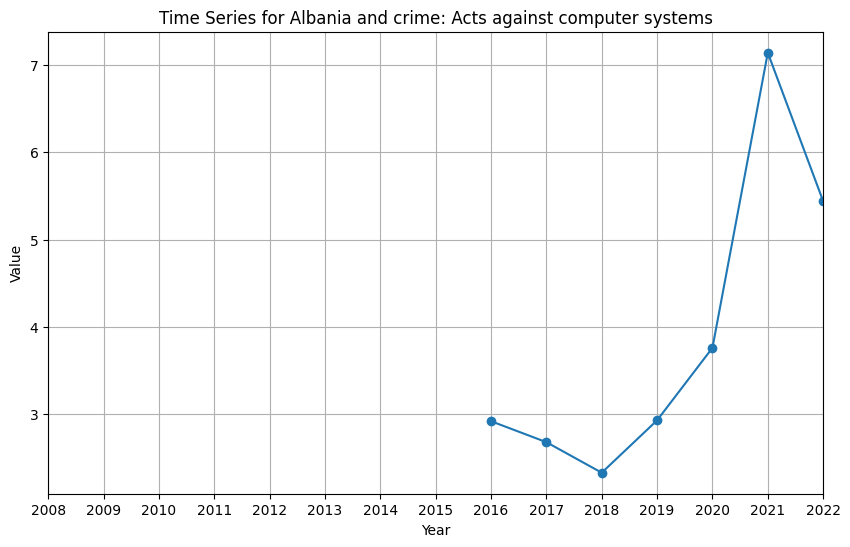

In [14]:
start_year, end_year = years_range.value
plt.figure(figsize=(10, 6))
plt.plot(CrimeData.filtered_data['year'], CrimeData.filtered_data['value'], marker='o')
plt.title(f"Time Series for {country.value} and crime: {crime.value}")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.xlim(start_year, end_year)
plt.xticks(range(start_year, end_year + 1, 1))
plt.show()

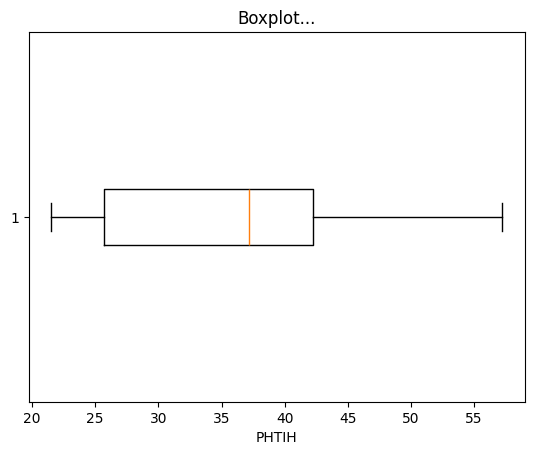

In [ ]:
plt.boxplot(CrimeData.filtered_data['value'].dropna(), vert=False, showfliers=True)
plt.xlabel('PHTIH')
plt.title('Boxplot...')

# Show plot
plt.show()

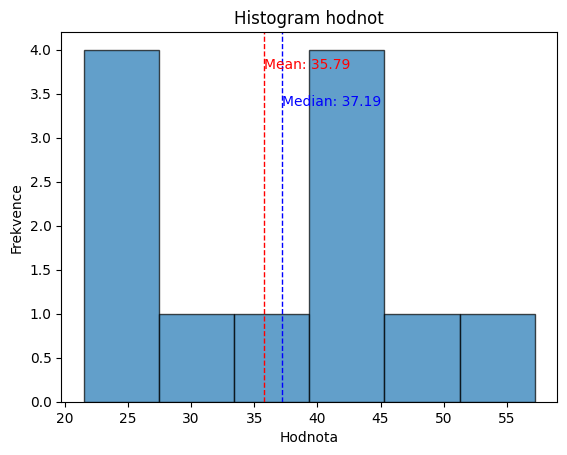

In [ ]:
# import seaborn as sns
# sns.histplot(CrimeData.filtered_data['value'], bins=6, kde=True)
plt.hist(CrimeData.filtered_data['value'], bins=6, edgecolor='black', alpha=0.7)

# Přidání názvů a popisků
plt.title('Histogram hodnot')
plt.xlabel('Hodnota')
plt.ylabel('Frekvence')

# Mean line
plt.axvline(CrimeData.statistics.mean_value, color = 'red', linestyle='dashed', linewidth=1)
plt.text(CrimeData.statistics.mean_value, plt.ylim()[1]*0.9, f'Mean: {CrimeData.statistics.mean_value:.2f}', color = 'red')

# Median line
plt.axvline(CrimeData.statistics.median_value, color='blue', linestyle='dashed', linewidth=1)
plt.text(CrimeData.statistics.median_value, plt.ylim()[1]*0.8, f'Median: {CrimeData.statistics.median_value:.2f}', color='blue')



# Zobrazení grafu
plt.show()